In [1]:
# Import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Import dependencies
import numpy as np
import pandas as pd

In [3]:
# Import dependencies
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)


In [10]:
# Inspect the column names of 'Measurement' table
inspector = inspect(engine)
inspector.get_table_names()
measurement_columns = inspector.get_columns('Measurement')
for measurement_column in measurement_columns:
    print(measurement_column["name"], measurement_column["type"])
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Inspect the column names of 'Station' table
station_columns = inspector.get_columns('Station')
for station_column in station_columns:
    print(station_column["name"], station_column["type"])
    

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# See the format of date
date = session.query(Measurement.date).limit(5).all()
date


[('2010-01-01'),
 ('2010-01-02'),
 ('2010-01-03'),
 ('2010-01-04'),
 ('2010-01-06')]

In [13]:
# Count of total dates in the database
total_date = session.query(func.count(Measurement.date)).all()
total_date


[(19550)]

In [14]:
# Get the latest date in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date


('2017-08-23')

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
yearFrom_latest_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

print(yearFrom_latest_date)


2016-08-23


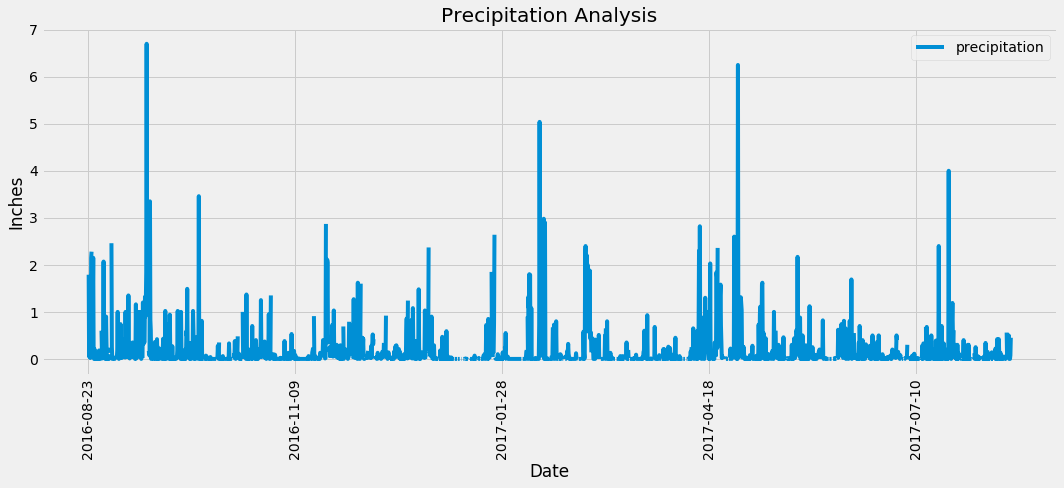

In [16]:

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) <= dt.date(2017, 8, 23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns = ["date", "precipitation"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(["date"])

# Set the date as index of the DataFrame
precipitation_df = precipitation_df.set_index("date")

# # Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(figsize = (15, 7), rot = "vertical")

# Set asthetics
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation Analysis")
plt.grid(which='minor')
plt.tight_layout()
# Save the plot
plt.savefig("Images/precipitation_analysis.png")

plt.show()


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).distinct().count()
print(f"{station_count} stations are available in this dataset.")

9 stations are available in this dataset.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# selection = [Station.station,
#             func.count(Measurement.station)]
active_station = session.query(Station.station, func.count(Measurement.station)).\
                join(Station, Station.station == Measurement.station).\
                group_by(Station.station).\
                order_by(func.count(Measurement.station).desc()).all()
#                 all()
for result in active_station:
    print(f"Station name : {result[0]}")
    print(f"Count : {result[1]}")
    print("---------------------------")


Station name : USC00519281
Count : 2772
---------------------------
Station name : USC00519397
Count : 2724
---------------------------
Station name : USC00513117
Count : 2709
---------------------------
Station name : USC00519523
Count : 2669
---------------------------
Station name : USC00516128
Count : 2612
---------------------------
Station name : USC00514830
Count : 2202
---------------------------
Station name : USC00511918
Count : 1979
---------------------------
Station name : USC00517948
Count : 1372
---------------------------
Station name : USC00518838
Count : 511
---------------------------


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = active_station[0][0]

temp_active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter_by(station = most_active_station).all()

for temp in temp_active_station:
    print(f"Lowest temperature recorded for station {most_active_station} is {temp_active_station[0][0]} Fahrenheit.")
    print(f"Highest temperature recorded for station {most_active_station} is {temp_active_station[0][1]} Fahrenheit.")
    print(f"Average temperature for station {most_active_station} is {round(temp_active_station[0][2], 2)} Fahrenheit.")
    


Lowest temperature recorded for station USC00519281 is 54.0 Fahrenheit.
Highest temperature recorded for station USC00519281 is 85.0 Fahrenheit.
Average temperature for station USC00519281 is 71.66 Fahrenheit.


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_observation = session.query(Measurement.date, Measurement.tobs).\
                            filter_by(station = most_active_station).\
                            filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).\
                            all()

active_station_df = pd.DataFrame(active_station_observation, columns = ["date", "temperature"])
active_station_df = active_station_df.set_index("date")
active_station_df.head()


,temperature
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


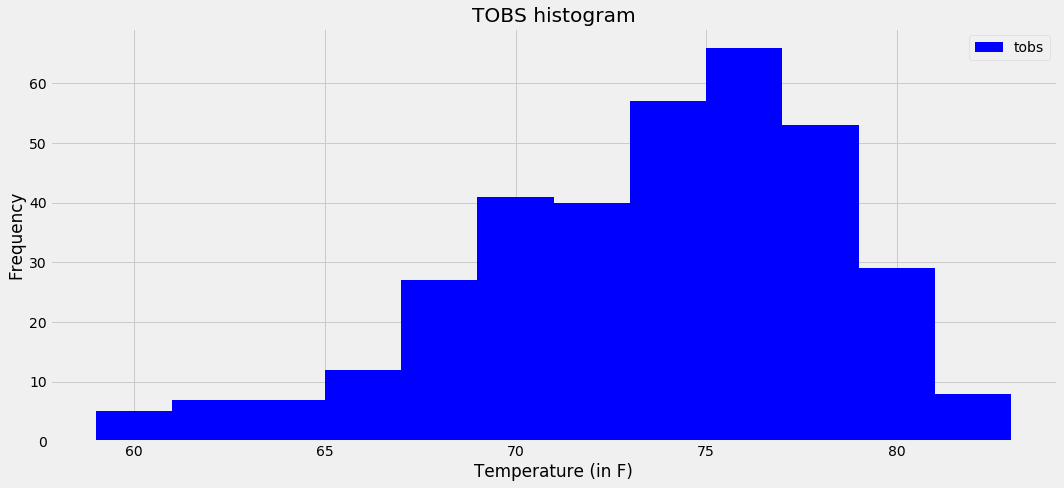

In [22]:
# Plot the histogram for the above DataFrame
active_station_df.hist(bins =12, color = "blue", figsize = (15, 7))

plt.xlabel("Temperature (in F)")
plt.ylabel("Frequency")
plt.legend(["tobs"], loc = "upper right")
plt.title("TOBS histogram")
plt.tight_layout()
plt.savefig("Images/tobs_histogram.png")
plt.show()


## Bonus Challenge Assignment

In [23]:
# Get data for the month of "June"
june_data = session.query(Measurement.station, func.avg(Measurement.tobs), Measurement.date).\
            filter(func.strftime("%m", Measurement.date) == "06").\
            group_by(Measurement.date, Measurement.station).\
            order_by(func.avg(Measurement.prcp)).all()

# Create DataFrame of the "June" data
june_df = pd.DataFrame(june_data, columns = ["Station", "Temperature", "Date"])

# Calculate mean of temperature
mean_june = june_df["Temperature"].mean()
mean_june


74.94411764705882

In [24]:
# Get data for the month of "December"
dec_data = session.query(Measurement.station, func.avg(Measurement.tobs), Measurement.date).\
            filter(func.strftime("%m", Measurement.date) == "12").\
            group_by(Measurement.date, Measurement.station).\
            order_by(func.avg(Measurement.prcp)).all()

# Create DataFrame of the "December" data
dec_df = pd.DataFrame(dec_data, columns = ["Station", "Temperature", "Date"])

# Calculate mean of temperature
mean_dec = dec_df["Temperature"].mean()
mean_dec


71.04152933421226

In [25]:
# Import dependencies
from scipy import stats

# Perform T-test
ttest = stats.ttest_ind(june_df['Temperature'], dec_df["Temperature"])
ttest


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = "2016-12-23"
trip_end_date = "2017-01-05"

trip_temp_data = calc_temps(trip_start_date, trip_end_date)

print(f"Lowest temperaure is {trip_temp_data[0][0]} Fahrenheit.")
print(f"Average temperaure is {round(trip_temp_data[0][1], 2)} Fahrenheit.")
print(f"Highest temperaure is {trip_temp_data[0][2]} Fahrenheit.")


Lowest temperaure is 62.0 Fahrenheit.
Average temperaure is 70.49 Fahrenheit.
Highest temperaure is 78.0 Fahrenheit.


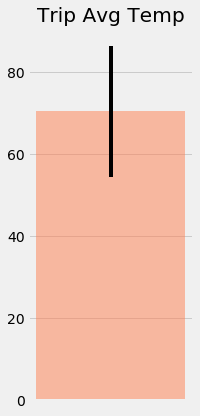

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = trip_temp_data[0][2] - trip_temp_data[0][0]
y_value = trip_temp_data[0][1]

fig, ax = plt.subplots(figsize = (3,6))
ax.bar(1, y_value,
       yerr = peak_to_peak, 
       color = 'coral',
       align='center',
       alpha=0.5,
       ecolor='black'
       )

ax.xaxis.set_visible(False)
plt.title("Trip Avg Temp")
plt.tight_layout()

plt.savefig("Images/trip_avg_temp.png")
plt.show()


In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_per_station = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                        join(Station, Measurement.station == Station.station).\
                        filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).\
                        group_by(Station.station).\
                        order_by(func.sum(Measurement.prcp).desc()).all()

rainfall_weather_df = pd.DataFrame(rainfall_per_station, columns = ["Station", "Name", "Latitude", "Longitude", "Elevation", "Precipitation"])

rainfall_weather_df
                    

,Station,Name,Latitude,Longitude,Elevation,Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,147.81
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,70.03
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,48.51
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,38.01
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.24
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.09
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.59


In [30]:
start_date = '2012-01-01'
end_date = '2012-01-07'
# filter(Measurement.date >= start_date).\
# filter(Measurement.date <= end_date).\


rainfall_per_station = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                        join(Station, Measurement.station == Station.station).\
                       filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).\
                        group_by(Station.station).\
                        order_by(func.sum(Measurement.prcp).desc()).all()

rainfall_weather_df = pd.DataFrame(rainfall_per_station, columns = ["Station", "Name", "Latitude", "Longitude", "Elevation", "Precipitation"])

rainfall_weather_df

,Station,Name,Latitude,Longitude,Elevation,Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.31
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.25
2,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.10
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.06
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00
7,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.00
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.00


In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = dt.date(2016,12,23)
end_date = dt.date(2017,1,5)
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
trip_dates = []
delta = end_date - start_date   

for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    trip_dates.append(day)

trip_month_day = [day.strftime("%m-%d") for day in trip_dates]

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in trip_month_day:
    daily_normal = daily_normals(date)
    normals.append(daily_normal)

tmin = []
tavg = []
tmax = []
for normal in normals:
    tmin.append(normal[0][0])
    tavg.append(normal[0][1])
    tmax.append(normal[0][2])


In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame({"date" : trip_dates,
             "Lowest Temperature" : tmin,
                    "Average Temperature" : tavg,
                "Highest Temperature" : tmax})
trip_df["date"] = pd.to_datetime(trip_df["date"]).dt.date
trip_df = trip_df.set_index("date")

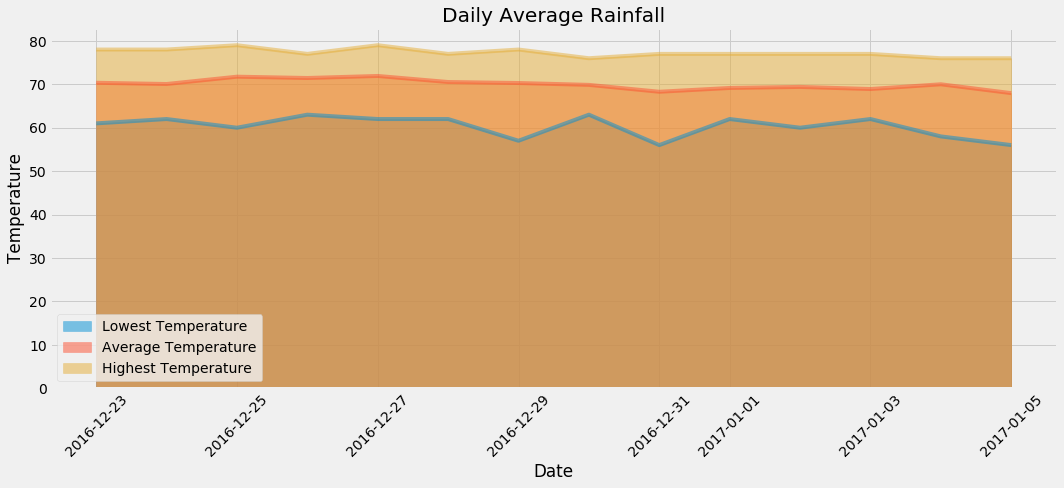

In [34]:
# Plot the daily normals as an area plot with `stacked=False`

# trip_df.plot.area(stacked = False)
trip_df.plot(kind = "area", x_compat = True, stacked = False, rot = 45, figsize =(15, 7))
plt.ylabel("Temperature")
plt.xlabel("Date")
plt.title("Daily Average Rainfall")
plt.tight_layout()
plt.savefig("Images/daily_average_rainfall.png")

plt.show()

